<a href="https://colab.research.google.com/github/rjz46/Cornell-Conversational-Analysis-Toolkit/blob/katy/datasets/reddit_coarse_discourse/Corpus_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [0]:
!pip install convokit
!python3 -m spacy download en
import nltk; nltk.download('punkt')
import convokit


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
import google
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
pip install --upgrade google-api-python-client


Requirement already up-to-date: google-api-python-client in /usr/local/lib/python3.6/dist-packages (1.7.11)


In [0]:
import json
from IPython.display import display as disp

from zipfile import ZipFile
import os

#Users: initialization

In [0]:
#@title Load json and make dict called "all_users" 
user_names = set()
DELETED_USER_NAME = '[deleted]'

with open('gdrive/My Drive/CS6742/coarse_discourse_dump_reddit_with_votes.json', 'r') as f:
  for line in f:
    json_obj = json.loads(line)
    for post in json_obj['posts']:
      if 'author' in post:
        user_names.add(post['author'])
      else:
        # I spot checked a post and comment, and it seems that a missing 'author' means it was deleted (post: t3_29mjj7, comment: t1_crzi5yt in reply to t3_391dim)
        user_names.add(DELETED_USER_NAME)

all_users = {user_name: convokit.User(name=user_name) for user_name in user_names}

print("Created {} users".format(len(all_users)))


Created 63573 users


In [0]:
#@title Check results
print("\nSample users:")
disp(list(all_users.items())[:3])


Sample users:


[('BiLaKaifa', User([('name', 'BiLaKaifa')])),
 ('nats15', User([('name', 'nats15')])),
 ('onnela', User([('name', 'onnela')]))]

#Utterances

In [0]:
#@title Make "utterance_corpus" dict
'''

id: index of the utterance
user: the user who author the utterance
root: index of the conversation root of the utterance
reply_to: index of the utterance to which this utterance replies to (None if the utterance is not a reply)
timestamp: time of the utterance
text: textual content of the utterance

meta: dictionary of utterance metadata
    post_depth, 
    majority type
    ann_types
    majority_linkann_links
    ups
    
'''
user_names = set()
DELETED_USER_NAME = '[deleted]'

with open('gdrive/My Drive/CS6742/coarse_discourse_dump_reddit_with_votes.json', 'r') as f:
  for line in f:
    json_obj = json.loads(line)
    for post in json_obj['posts']:
      if 'author' in post:
        user_names.add(post['author'])
      else:
        # I spot checked a post and comment, and it seems that a missing 'author' means it was deleted (post: t3_29mjj7, comment: t1_crzi5yt in reply to t3_391dim)
        user_names.add(DELETED_USER_NAME)

all_users = {user_name: convokit.User(name=user_name) for user_name in user_names}

utterance_corpus = {}
      
with open('gdrive/My Drive/CS6742/coarse_discourse_dump_reddit_with_votes.json', 'r') as f:
    for line in f:
      json_obj = json.loads(line)

      root = json_obj['posts'][0]['id']

      for post in json_obj['posts']:
        
        idx = post['id'] 
        text = post['body'] if 'body' in post else None
        user, post_depth, in_reply_to = None, None, None
        
        if 'author' in post:
          user = post['author']
        else:
          user = DELETED_USER_NAME

        if 'is_first_post' in post:
          in_reply_to = None
          post_depth = 0
        else:
          in_reply_to = post['in_reply_to']
          post_depth = post['post_depth']

        annotations = post['annotations']  
  
        metadata = {
          'post_depth': post_depth,
          'majority_type': post['majority_type'] if 'majority_type' in post else None,
          'majority_link': post['majority_link'] if 'majority_link' in post else None,
          'annotation-types': [annotation['main_type'] for annotation in annotations],
          'annotation-links': [annotation['link_to_post'] if 'link_to_post' in annotation else None for annotation in annotations],
          'ups': post['ups'] if 'ups' in post else None

        }

        utterance_corpus[idx] = convokit.Utterance(idx, all_users[user], root, in_reply_to, None, text, meta=metadata)
      
    

In [0]:
print(len(user_names))
print(len(utterance_corpus))
disp(list(utterance_corpus.items())[:10])

63573
115827


[('t3_1bx6qw',
  Utterance({'id': 't3_1bx6qw', 'user': User([('name', 'DTX120')]), 'root': 't3_1bx6qw', 'reply_to': None, 'timestamp': None, 'text': "4/7/13  \n\n7/27/12  \n\nhttp://www.imdb.com/title/tt0073440/reference\n\nIt was only a few minutes into Robert Altman's homespun epic *Nashville* that I got the feeling I was watching a great movie. By the end it could not be denied. Now I'm sure it helps that I'm a musician, since this created an immediate connection to the subject matter. I spent a portion of the movie with my Telecaster in my lap trying to play along with the characters who all seem to be really playing and singing these songs. However I also am *not* a fan of country western, so that could have easily been a turn off.  \n\nTo begin describing the action in the film is daunting. I can't even process a lot of what I saw. This movie is extremely dense, and the first 30 minutes or so are spent just trying to figure out who people are. Their relationships to one another -

#Conversation

In [0]:
#@title Make "conversation_corpus" dict

conversation_corpus = {}
with open('gdrive/My Drive/CS6742/coarse_discourse_dump_reddit_with_votes.json', 'r') as f:
  for line in f:
    json_obj = json.loads(line)
    
    posts = json_obj["posts"]
    first = posts[0]
    
    #print(first)
    
    if(first.get('author')!=None):
      owner = first['author']
    else:
      owner = '[deleted]'
    
    convo_id = first['id'][:]
    
    comments = []
    
    for comment in posts[:]:
      comments.append(comment['id'][:])
    
    meta_data = {
        "subreddit": json_obj['subreddit'], 
        "url": json_obj['url'],
        "title": json_obj['title']}
    
    conversation_corpus[convo_id] = convokit.Conversation(owner, convo_id, comments, meta_data)
    

In [0]:
print(conversation_corpus['t3_1bx6qw'])

Conversation({'_owner': 'DTX120', '_id': 't3_1bx6qw', '_utterance_ids': ['t3_1bx6qw', 't1_c9b2nyd', 't1_c9b30i1', 't1_c9b6sj0'], '_usernames': None, '_meta': {'subreddit': '100movies365days', 'url': 'https://www.reddit.com/r/100movies365days/comments/1bx6qw/dtx120_87_nashville/', 'title': 'DTX120: #87 - Nashville'}})


# Users: add utterances

In [0]:
#@title Test that adding utterances to users also updates user object attached to utterances

test_users = {user_name: convokit.User(name=user_name) for user_name in ['user1', 'user2', 'user3']}

test_utterances = {
    'id1.1': convokit.Utterance('id1.1', test_users['user1'], None, None, None, 'some_text'),
    'id1.2': convokit.Utterance('id1.2', test_users['user1'], None, None, None, 'some_text'),
    'id2.1': convokit.Utterance('id2.1', test_users['user2'], None, None, None, 'some_text'),
}

test_convos = {
    'id1.1': convokit.Conversation(owner=None, id="id1.1", utterances=['id1.1', 'id2.1']),
    'id1.2': convokit.Conversation(owner=None, id="id1.2", utterances=['id1.2'])
    
}


for utt in test_utterances.values():
  utt.user.utterances[utt.id] = utt
  
for i, convo in enumerate(test_convos.values()):
  top_post = test_utterances[convo.id]
  top_post.user.conversations[convo.id] = convo

print("All test users, with associated utterance keys:")
for uid, user in test_users.items():
  print("\tUser ID: {} \tUtterance keys: {}".format(uid, list(user.utterances.keys())))
  
print()

print("All test users, with associated convo keys:")
for uid, user in test_users.items():
  print("\tUser ID: {} \tConvo keys: {}".format(uid, list(user.conversations.keys())))
  
print()

print("All test utterances, with associated user, and user's associated utterance keys:")
for utt_id, utt in test_utterances.items():
  print("\tUtt. ID: {} \tUser ID: {} \tUser's utt. keys: {}".format(utt_id, utt.user.name, list(utt.user.utterances.keys())))

All test users, with associated utterance keys:
	User ID: user1 	Utterance keys: ['id1.1', 'id1.2']
	User ID: user2 	Utterance keys: ['id2.1']
	User ID: user3 	Utterance keys: []

All test users, with associated convo keys:
	User ID: user1 	Convo keys: ['id1.1', 'id1.2']
	User ID: user2 	Convo keys: []
	User ID: user3 	Convo keys: []

All test utterances, with associated user, and user's associated utterance keys:
	Utt. ID: id1.1 	User ID: user1 	User's utt. keys: ['id1.1', 'id1.2']
	Utt. ID: id1.2 	User ID: user1 	User's utt. keys: ['id1.1', 'id1.2']
	Utt. ID: id2.1 	User ID: user2 	User's utt. keys: ['id2.1']


In [0]:
#@title Add utterances to all_users

for i, utt in enumerate(utterance_corpus.values()):
  utt.user.utterances[utt.id] = utt
  
print("Added {} utterances to all_users".format(i+1))

Added 115827 utterances to all_users


In [0]:
#@title Add convos to all_users
for i, convo in enumerate(conversation_corpus.values()):
  top_post = utterance_corpus[convo.id]
  top_post.user.conversations[convo.id] = convo
  
print("Added {} convos to all_users".format(i+1))

Added 9483 convos to all_users


#Corpus

In [0]:
#@title Create corpus and add conversation metadata
utterance_list = [utterance for k,utterance in utterance_corpus.items()]
reddit_corpus = convokit.Corpus(utterances=utterance_list, version=1)

for convo_id in reddit_corpus.get_conversation_ids():
  reddit_corpus.get_conversation(convo_id).meta = conversation_corpus[convo_id].meta

convo_ids = reddit_corpus.get_conversation_ids()
for i, convo_idx in enumerate(convo_ids[0:5]):
    print("sample conversation {}:".format(convo_idx))
    convo = reddit_corpus.get_conversation(convo_idx)
    user_id = convo.get_utterance(convo.id).user.name
    print("Meta: ", convo.meta)


sample conversation t3_1bx6qw:
Meta:  {'subreddit': '100movies365days', 'url': 'https://www.reddit.com/r/100movies365days/comments/1bx6qw/dtx120_87_nashville/', 'title': 'DTX120: #87 - Nashville'}
sample conversation t3_omv7p:
Meta:  {'subreddit': '100sets', 'url': 'https://www.reddit.com/r/100sets/comments/omv7p/male_23_years_old_going_for_100_sets/', 'title': 'Male, 23 years old. Going for 100 sets!'}
sample conversation t3_259tbh:
Meta:  {'subreddit': '1200isplenty', 'url': 'https://www.reddit.com/r/1200isplenty/comments/259tbh/122cal_black_currant_cheesecake/', 'title': '122cal black currant cheesecake!'}
sample conversation t3_16h61h:
Meta:  {'subreddit': '1911', 'url': 'https://www.reddit.com/r/1911/comments/16h61h/need_help_finding_a_springfield/', 'title': 'Need help finding a Springfield!'}
sample conversation t3_35igzp:
Meta:  {'subreddit': '1911', 'url': 'https://www.reddit.com/r/1911/comments/35igzp/help_with_a_possible_trade/', 'title': 'Help with a possible trade?'}


In [0]:
# @title Save to file and zip
reddit_corpus.dump("reddit_coarse_discourse", base_path = "gdrive/My Drive/CS6742/")

with ZipFile("gdrive/My Drive/CS6742/reddit_coarse_discourse.zip", 'w') as zip_f:
  for fname in os.listdir("gdrive/My Drive/CS6742/reddit_coarse_discourse"):
    zip_f.write("gdrive/My Drive/CS6742/reddit_coarse_discourse/"+fname)

KeyboardInterrupt: ignored

In [0]:
#@title Show stats

print(len(reddit_corpus.get_utterance_ids()))
print(len(reddit_corpus.get_conversation_ids()))
print(len(reddit_corpus.get_usernames()))
reddit_corpus.print_summary_stats()

115827
9483
63573
Number of Users: 63573
Number of Utterances: 115827
Number of Conversations: 9483


# Part D: Stats and politeness transform

## Discourse type stats

In [0]:
type_corpus = {}
type_list = []

for x in utterance_corpus:
  #type_corpus[x] = utterance_corpus[x].meta["majority_type"]
  if(utterance_corpus[x].meta["majority_type"]==None):
    type_list.append("no consensus")
  else:
    type_list.append(utterance_corpus[x].meta["majority_type"])
  
#print(type_list)

from collections import Counter

ctrdata = Counter(type_list)

announcement 2002 1.73%
elaboration 19258 16.63%
humor 2417 2.09%
appreciation 8710 7.52%
question 17594 15.19%
answer 41162 35.54%
no consensus 12277 10.6%
agreement 5040 4.35%
negativereaction 1896 1.64%
disagreement 3422 2.95%
other 2049 1.77%


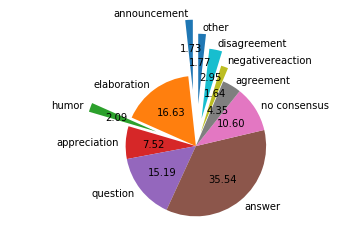

In [0]:
#https://pythontic.com/visualization/charts/piechart
import matplotlib.pyplot as plotter

for x in ctrdata:
  y = ctrdata[x]
  percenty = y / 115827 * 100;
  print(x + " " + str(y) + " " + str(round(percenty,2)) + "%")

uttlabels = ctrdata.keys()
data = ctrdata.values()

explode = (0.8, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.4, 0.6)

figureObject, axesObject = plotter.subplots()

# Draw the pie chart

axesObject.pie(data,explode=explode,

        labels=uttlabels,

        autopct='%1.2f',

        startangle=90)

 

# Aspect ratio - equal means pie is a circle

axesObject.axis('equal')

 

plotter.show()

## Politeness transform

In [0]:
#@title Prep corpus by running parser
parser = convokit.Parser()
reddit_corpus = parser.transform(reddit_corpus)

In [0]:
# @title Save again
reddit_corpus.dump("reddit_coarse_discourse_with_parsed", base_path = "gdrive/My Drive/CS6742/")

with ZipFile("gdrive/My Drive/CS6742/reddit_coarse_discourse_with_parsed.zip", 'w') as zip_f:
  for fname in os.listdir("gdrive/My Drive/CS6742/reddit_coarse_discourse_with_parsed"):
    zip_f.write("gdrive/My Drive/CS6742/reddit_coarse_discourse_with_parsed/"+fname)

In [0]:
#@title Get politeness strategies

ps = convokit.PolitenessStrategies()
reddit_corpus = ps.transform(reddit_corpus)

In [0]:
# @title Save one more time
reddit_corpus.dump("reddit_coarse_discourse_with_parsed_and_politeness", base_path = "gdrive/My Drive/CS6742/")

with ZipFile("gdrive/My Drive/CS6742/reddit_coarse_discourse_with_parsed_and_politeness.zip", 'w') as zip_f:
  for fname in os.listdir("gdrive/My Drive/CS6742/reddit_coarse_discourse_with_parsed_and_politeness"):
    zip_f.write("gdrive/My Drive/CS6742/reddit_coarse_discourse_with_parsed_and_politeness/"+fname)